## Import required libraries

In [41]:
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import CIFAR10


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from timeit import default_timer as timer

In [2]:
!pip install -q torchmetrics
from torchmetrics.classification import MulticlassAccuracy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 20.2 MB/s eta 0:00:00


## Device agnostic code

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Load dataset

In [11]:
transform = transforms.Compose([
                                  transforms.Resize((32, 32)),
                                  transforms.ToTensor()
                              ])

train_transform_trivial_augment = transforms.Compose([
    # transforms.Grayscale(),
    transforms.RandomRotation(10),
    transforms.GaussianBlur(kernel_size = 3, sigma = 0.01),
    transforms.ToTensor()
])

In [12]:
train_data = CIFAR10(root = '/data', train = True, transform = transform, download = True)
train_data_aug = CIFAR10(root = 'data', train = True, transform = train_transform_trivial_augment, download = True)
test_data = CIFAR10(root = '/data', train = False, transform = transform, download = True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [13]:
len(train_data), len(test_data)

(50000, 10000)

## get only even class

In [14]:
train_list = []
train_aug_list = []
test_list = []


for i, (x,y) in enumerate(train_data):
  if y % 2 == 0:
    train_list.append(train_data[i])
  # print(train_data[i])
  # break
for i, (x,y) in enumerate(train_data_aug):
  if y % 2 == 0:
    train_aug_list.append(train_data_aug[i])

for x,y in test_data:
  if y % 2 == 0:
    test_list.append((x, y))

len(train_list), len(train_aug_list), len(test_list)

(25000, 25000, 5000)

In [15]:
# concate datasets
new_train_data = torch.utils.data.ConcatDataset((train_list, train_aug_list))
new_test_data = torch.utils.data.ConcatDataset([test_list])

In [16]:
len(new_train_data), len(new_test_data)

(50000, 5000)

## Make dataloader

In [17]:
BATCH_SIZE = 32

# train dataloader
train_dataloader = DataLoader(dataset = new_train_data, batch_size = BATCH_SIZE, shuffle = True)

# test dataloader
test_dataloader = DataLoader(dataset = new_test_data, batch_size = BATCH_SIZE, shuffle = False)

In [18]:
print(f'Total {len(train_dataloader)} of train each of {BATCH_SIZE} batches.')
print(f'Total {len(test_dataloader)} of test each of {BATCH_SIZE} batches.')

Total 1563 of train each of 32 batches.
Total 157 of test each of 32 batches.


In [19]:
# class name
class_names = [train_data.classes[i] for i in range(len(train_data.classes)) if i % 2 == 0] 
class_names

['airplane', 'bird', 'deer', 'frog', 'ship']

image_shape: torch.Size([3, 32, 32])


Text(0.5, 1.0, 'ship')

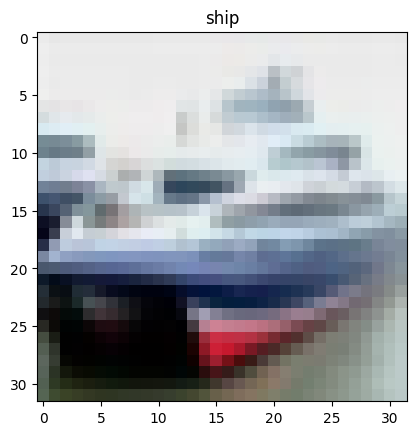

In [21]:
image, label = new_test_data[0]
print(f"image_shape: {image.shape}")
plt.imshow(image.permute(1,2,0).squeeze())
plt.title(class_names[label//2])

## Train and Test Loop

In [22]:
# train
def train_loop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer,
               accuracy_fn, device: torch.device = device):
  
  model.train()

  train_loss, train_acc = 0, 0
  for batch, (x_train, y_train) in enumerate(dataloader):
    
    if device == 'cuda':
      x_train, y_train = x_train.to(device), y_train.to(device)

    
    y_train = y_train // 2
    # 1. Forward step
    pred = model(x_train)

    # 2. Loss
    loss = loss_fn(pred, y_train)
    

    # 3. Grad zerostep
    optimizer.zero_grad()

    # 4. Backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    acc = accuracy_fn(y_train, torch.argmax(pred, dim=1))
    train_loss += loss
    train_acc += acc

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc


# test
def test_loop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module, accuracy_fn, 
              device: torch.device = device):
  
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for x_test, y_test in dataloader:

      if device == 'cuda':
        x_test, y_test = x_test.to(device), y_test.to(device)

      y_test = y_test // 2
      # 1. Forward
      test_pred = model(x_test)
      
      # 2. Loss and accuray
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_test, torch.argmax(test_pred, dim=1))

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss, test_acc

## Plot function for Loss / Accuracy VS Epoch

In [23]:
def plot_graph(train_losses, test_losses, train_accs, test_accs):
  plt.figure(figsize = (20, 8))
  plt.subplot(1, 2, 1)
  plt.plot(range(len(train_losses)), train_losses, label = "Train Loss")
  plt.plot(range(len(test_losses)), test_losses, label = "Test Loss")
  plt.legend()
  plt.xlabel("Epoches")
  plt.ylabel("Loss")
  # plt.show()

  plt.subplot(1, 2, 2)
  plt.plot(range(len(train_accs)), train_accs, label = "Train Accuracy")
  plt.plot(range(len(test_accs)), test_accs, label = "Test Accuracy")
  plt.legend()
  plt.xlabel("Epoches")
  plt.ylabel("Accuracy")
  plt.show()

## Loss and Accuracy Function

In [24]:
# loss
loss_fn = nn.CrossEntropyLoss()

# accuray
accuracy_fn = MulticlassAccuracy(num_classes = 10).to(device)

# Build model

## using cosine positional embedding

In [33]:
# patch class
class PatchEmbeddings(nn.Module):
    def __init__(self, img_size, patch_size, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        self.flatten = nn.Flatten()
        self.patcher = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        #x = image (batchsize, channels, row, cols)                 
        x = self.patcher(x)  # (batchsize, embed_dim, n_patches ** 0.5, n_patches ** 0.5)

        # print(x.shape)
        x = x.flatten(2)  # (batchsize, embed_dim, n_patches)
        # print(x.shape)
        x = x.transpose(1, 2)  # (batchsize, n_patches, embed_dim)

        return x

In [34]:
# cosin pos encoding
class CosinePositionalEncoding(nn.Module):
    def __init__(self, max_seq_length, hidden_size):
        super(CosinePositionalEncoding, self).__init__()
        self.max_seq_length = max_seq_length
        self.hidden_size = hidden_size
        self.pos_enc = self._get_positional_encoding()

    def _get_positional_encoding(self):
        pos_enc = torch.zeros(self.max_seq_length, self.hidden_size)
        position = torch.arange(0, self.max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.hidden_size, 2).float() * (-np.log(10000.0) / self.hidden_size))
        pos_enc[:, 0::2] = torch.sin(position * div_term)
        pos_enc[:, 1::2] = torch.cos(position * div_term)
        pos_enc = pos_enc.unsqueeze(0)
        return pos_enc.to(device)

    def forward(self, x):
        batch_size, seq_length, hidden_size = x.shape
        x = x + self.pos_enc[:, :seq_length, :]
        return x

In [35]:
# learnabel pos encoding
class LearnablePositionalEncoding(nn.Module):
    def __init__(self, seq_length, embed_size):
        super(LearnablePositionalEncoding, self).__init__()

        self.pos_enc = nn.Parameter(torch.randn(seq_length, embed_size))

    def forward(self, x):
        pos = torch.arange(x.size(1), device=x.device).unsqueeze(0)
        x = x + self.pos_enc[pos, :]
        return x

In [36]:
# MLP
class MLP(nn.Module):
  def __init__(self, in_features, hidden_features, out_features, p=0.2):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(in_features, hidden_features)
    
    self.act = nn.GELU()
    
    self.fc2 = nn.Linear(hidden_features, out_features)
    self.drop = nn.Dropout(p)

  def forward(self, x):
    x = self.fc1(x) # (batchsize, n_patches + 1, hidden_features)
    x = self.act(x)
    x = self.drop(x) 
    x = self.fc2(x)  # (batchsize, n_patches + 1, out_features)
    x = self.drop(x) 

    return x

In [38]:
# self attention
class Attention(nn.Module):

    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0.1, proj_p=0.1):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)

    def forward(self, x):
        
        n_samples, n_tokens, dim = x.shape #n_samples -> batch_size

        if dim != self.dim:
            raise ValueError

        qkv = self.qkv(x)  # (n_samples, n_patches + 1, 3 * dim)
        qkv = qkv.reshape( n_samples, n_tokens, 3, self.n_heads, self.head_dim)  # (n_smaples, n_patches + 1, 3, n_heads, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, n_samples, n_heads, n_patches + 1, head_dim)

        q, k, v = qkv[0], qkv[1], qkv[2]
        k_t = k.transpose(-2, -1)  # (n_samples, n_heads, head_dim, n_patches + 1)
        dp = (q @ k_t) * self.scale # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = dp.softmax(dim= 1)  # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = self.attn_drop(attn)

        weighted_avg = attn @ v  # (n_samples, n_heads, n_patches +1, head_dim)
        weighted_avg = weighted_avg.transpose(
                1, 2
        )  # (n_samples, n_patches + 1, n_heads, head_dim)
        weighted_avg = weighted_avg.flatten(2)  # (n_samples, n_patches + 1, dim)

        x = self.proj(weighted_avg)  # (n_samples, n_patches + 1, dim)
        x = self.proj_drop(x)  # (n_samples, n_patches + 1, dim)

        return x

In [39]:
# Transformer block
class TransformerBlock(nn.Module):
  def __init__(self, dim, num_heads, mlp_ratio = 4, attention_p = 0.3, bias = True, add_bias_kv = True):
    super().__init__()
    self.layernorm1 = nn.LayerNorm(dim, eps=1e-6)

    self.qkv = nn.Linear(dim, dim * 3, bias = add_bias_kv)
    #self.attention = nn.MultiheadAttention(dim, num_heads, dropout = attention_p, bias = True, add_bias_kv = True)
    self.attention = Attention(dim, num_heads)
    self.layernorm2 = nn.LayerNorm(dim, eps=1e-6)
    hidden_features = int(dim * mlp_ratio)
    self.mlp = MLP(in_features=dim, hidden_features = hidden_features, out_features=dim)

  def forward(self, x):
    #batchsize, n_tokens, dim = x.shape
    #self.qkv
    x = x + self.attention(self.layernorm1(x))
    x = x + self.mlp(self.layernorm2(x))

    return x

In [43]:
# vision tran
class VisionTransformer(nn.Module):
  def __init__(self, image_size = 32, patch_size = 16, in_channels = 3, classes = 10, embd_dim = 768, depth = 12,
               num_heads = 6, mlp_ratio = 4, p = 0.2, attention_p = 0.2, 
               activation = 'relu', learn_pos_encode = False, num_blocks = 4):
    super().__init__()

    self.patching = PatchEmbeddings(image_size, patch_size, in_channels, embd_dim)

    self.n_patches = self.patching.n_patches

    if learn_pos_encode:
      self.pos_embedding = LearnablePositionalEncoding(self.n_patches, embd_dim)
    else:
      self.pos_embedding = CosinePositionalEncoding(self.n_patches, embd_dim).to(device)


    self.blocks = nn.ModuleList([
            TransformerBlock(embd_dim, num_heads, mlp_ratio, bias = True, add_bias_kv = True)
            for _ in range(num_blocks)
        ])

    self.decoder1 = TransformerBlock(embd_dim, num_heads, mlp_ratio, bias = True, add_bias_kv = True)

    self.layernorm = nn.LayerNorm(embd_dim, eps=1e-6)
    self.fc = nn.Linear(embd_dim, classes)

    if activation == 'relu':
      self.act = nn.ReLU()
    else:
      self.act = nn.Tanh()

    self.softmax = nn.Softmax(dim = 1)
  
  def forward(self, x):

    x = self.patching(x)
    x = self.pos_embedding(x)

    for block in self.blocks:
      x = self.act(block(x))

    
    x = self.layernorm(x)
    #print(x.shape)
    cls_token_final = x[:, 0]
    x = self.fc(cls_token_final)
    return x


# train model

## cosin pos with relu

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 1.3966 | Test Loss: 1.3084 | Train Accuray: 0.1132 | Test Accuracy: 0.1375
Epoch: 2  Train Loss: 1.3203 | Test Loss: 1.2955 | Train Accuray: 0.1604 | Test Accuracy: 0.2037
Epoch: 3  Train Loss: 1.2851 | Test Loss: 1.2333 | Train Accuray: 0.2041 | Test Accuracy: 0.2180
Epoch: 4  Train Loss: 1.2574 | Test Loss: 1.2347 | Train Accuray: 0.2126 | Test Accuracy: 0.1777
Epoch: 5  Train Loss: 1.2712 | Test Loss: 1.2681 | Train Accuray: 0.2076 | Test Accuracy: 0.2195
Epoch: 6  Train Loss: 1.2548 | Test Loss: 1.2273 | Train Accuray: 0.2146 | Test Accuracy: 0.2278
Epoch: 7  Train Loss: 1.2320 | Test Loss: 1.2169 | Train Accuray: 0.2270 | Test Accuracy: 0.2273
Epoch: 8  Train Loss: 1.2216 | Test Loss: 1.1714 | Train Accuray: 0.2332 | Test Accuracy: 0.2483
Epoch: 9  Train Loss: 1.1852 | Test Loss: 1.1559 | Train Accuray: 0.2436 | Test Accuracy: 0.2569
Epoch: 10  Train Loss: 1.1748 | Test Loss: 1.1906 | Train Accuray: 0.2480 | Test Accuracy: 0.2487
Epoch: 11  Train Loss: 1.1799

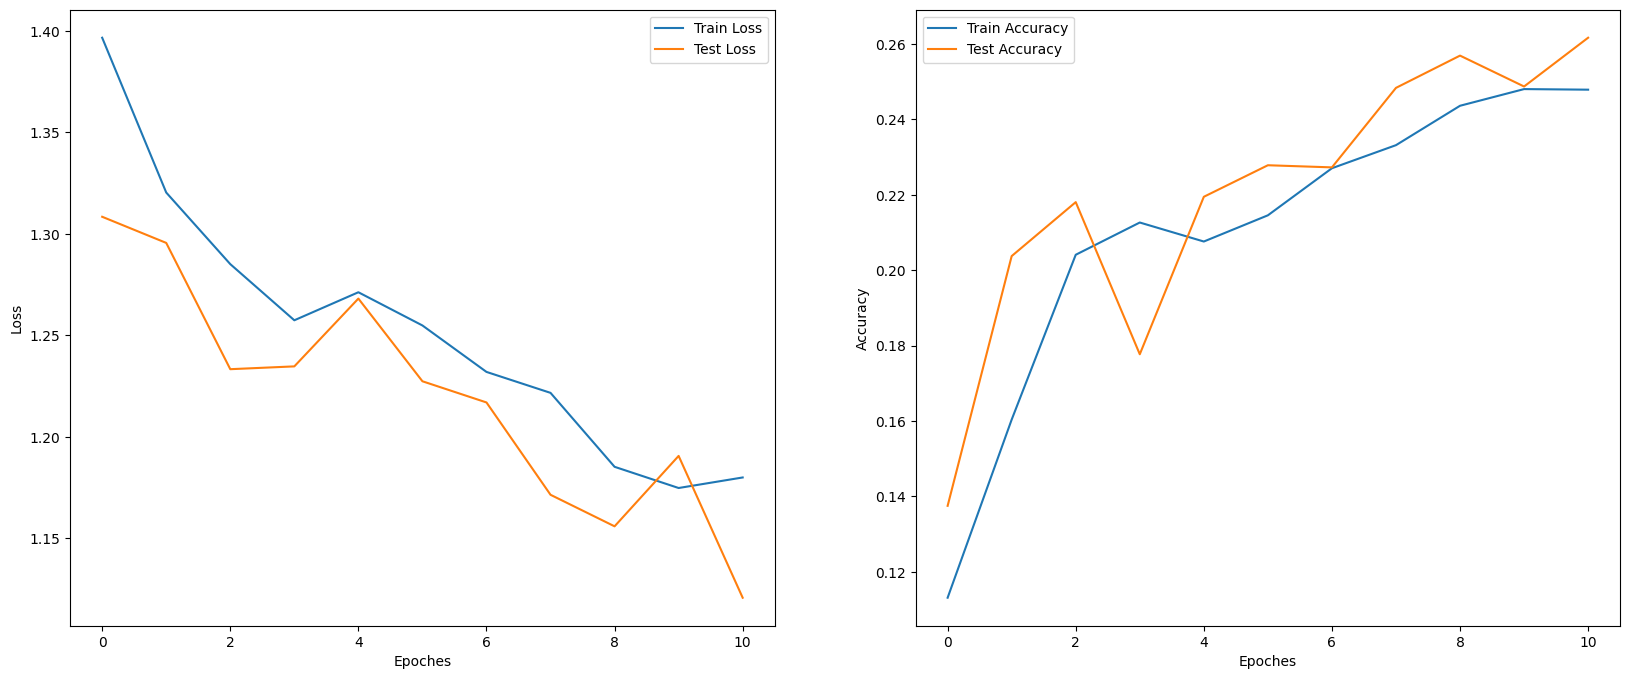

train ing time: 637.9368668800003


In [44]:
# init. epochs
epoches = 11

cos_pos_relu = VisionTransformer(learn_pos_encode = False, num_heads = 8, num_blocks = 6, activation = 'relu').to(device)

# optimizer
optimizer = torch.optim.Adam(params = cos_pos_relu.parameters(), lr = 1e-3)
cos_pos_relu_train_loss, cos_pos_relu_test_loss = [], []
cos_pos_relu_train_accs, cos_pos_relu_test_accs = [], []


torch.manual_seed(64)
torch.cuda.manual_seed(64)
start_time = timer()
for epoch in tqdm(range(epoches)):

  train_loss, train_acc = train_loop(model = cos_pos_relu, dataloader = train_dataloader,
                                    loss_fn = loss_fn, optimizer = optimizer,
                                    accuracy_fn = accuracy_fn, device = device)
  
  test_loss, test_acc = test_loop(model = cos_pos_relu, dataloader = test_dataloader,
                                  loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                                  device = device)
  
  cos_pos_relu_train_loss.append(train_loss.item())
  cos_pos_relu_test_loss.append(test_loss.item())
  cos_pos_relu_train_accs.append(train_acc.item())
  cos_pos_relu_test_accs.append(test_acc.item())

  print(f"Epoch: {epoch+1}  Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Accuray: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")

end_time = timer()
plot_graph(cos_pos_relu_train_loss, cos_pos_relu_test_loss, cos_pos_relu_train_accs, cos_pos_relu_test_accs)
print(f"train ing time: {end_time - start_time}")

# save_model('cifair10_cos_pos_relu.pth', cos_pos_relu)
# print("Model saved")

## learn pos with relu

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 1.3877 | Test Loss: 1.3020 | Train Accuray: 0.1174 | Test Accuracy: 0.1300
Epoch: 2  Train Loss: 1.3020 | Test Loss: 1.2931 | Train Accuray: 0.1870 | Test Accuracy: 0.1931
Epoch: 3  Train Loss: 1.2666 | Test Loss: 1.2100 | Train Accuray: 0.2110 | Test Accuracy: 0.2345
Epoch: 4  Train Loss: 1.2544 | Test Loss: 1.2233 | Train Accuray: 0.2147 | Test Accuracy: 0.2179
Epoch: 5  Train Loss: 1.2722 | Test Loss: 1.2809 | Train Accuray: 0.2055 | Test Accuracy: 0.1848
Epoch: 6  Train Loss: 1.2397 | Test Loss: 1.1959 | Train Accuray: 0.2255 | Test Accuracy: 0.2409
Epoch: 7  Train Loss: 1.2312 | Test Loss: 1.2059 | Train Accuray: 0.2242 | Test Accuracy: 0.2319
Epoch: 8  Train Loss: 1.2090 | Test Loss: 1.1571 | Train Accuray: 0.2355 | Test Accuracy: 0.2418
Epoch: 9  Train Loss: 1.1876 | Test Loss: 1.1285 | Train Accuray: 0.2424 | Test Accuracy: 0.2549
Epoch: 10  Train Loss: 1.1640 | Test Loss: 1.1152 | Train Accuray: 0.2538 | Test Accuracy: 0.2625
Epoch: 11  Train Loss: 1.1410

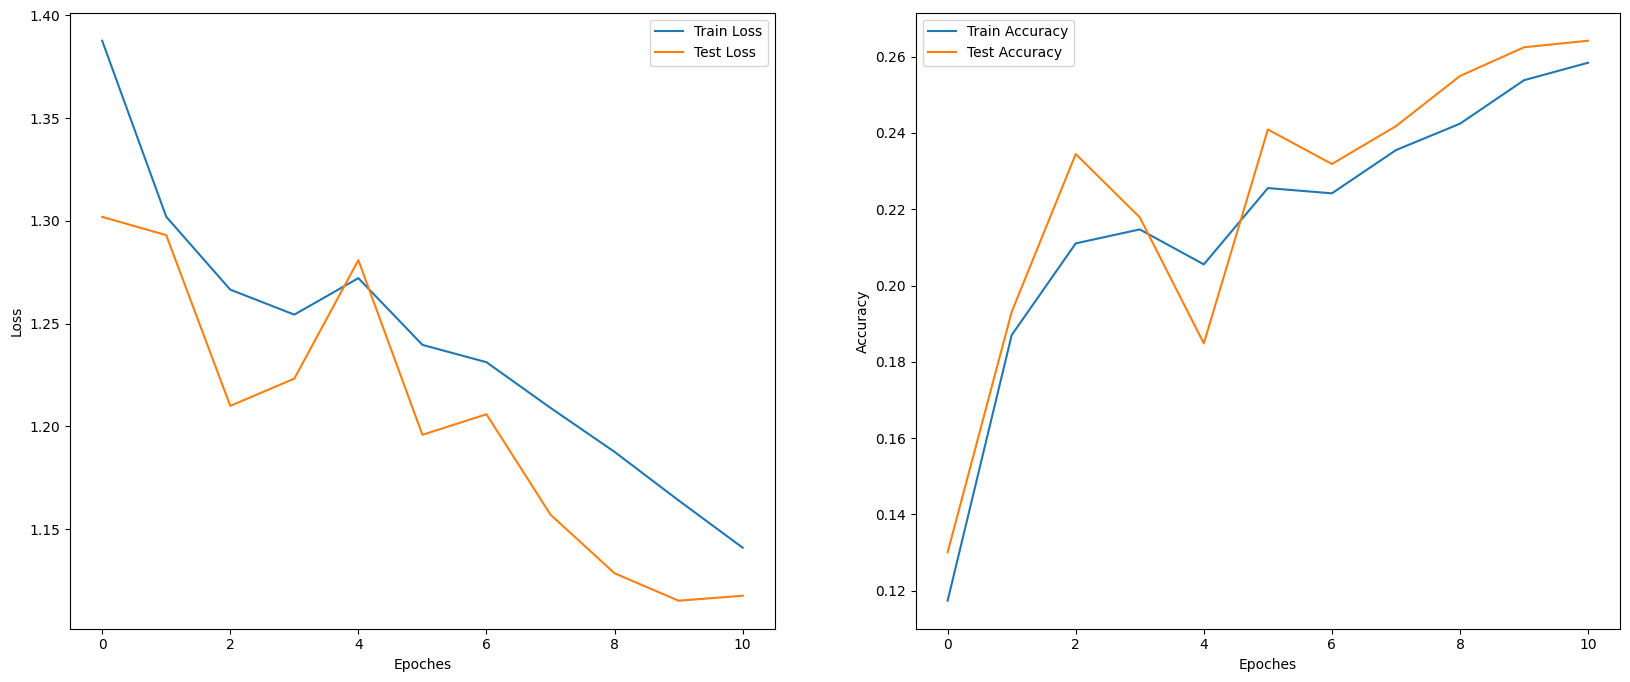

train ing time: 587.6857188160002


In [45]:
# init. epochs
epoches = 11

learn_pos_relu = VisionTransformer(learn_pos_encode = True, num_heads = 8, num_blocks = 6, activation = 'relu').to(device)

# optimizer
optimizer = torch.optim.Adam(params = learn_pos_relu.parameters(), lr = 1e-3)
learn_pos_relu_train_loss, learn_pos_relu_test_loss = [], []
learn_pos_relu_train_accs, learn_pos_relu_test_accs = [], []


torch.manual_seed(64)
torch.cuda.manual_seed(64)
start_time = timer()
for epoch in tqdm(range(epoches)):

  train_loss, train_acc = train_loop(model = learn_pos_relu, dataloader = train_dataloader,
                                    loss_fn = loss_fn, optimizer = optimizer,
                                    accuracy_fn = accuracy_fn, device = device)
  
  test_loss, test_acc = test_loop(model = learn_pos_relu, dataloader = test_dataloader,
                                  loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                                  device = device)
  
  learn_pos_relu_train_loss.append(train_loss.item())
  learn_pos_relu_test_loss.append(test_loss.item())
  learn_pos_relu_train_accs.append(train_acc.item())
  learn_pos_relu_test_accs.append(test_acc.item())

  print(f"Epoch: {epoch+1}  Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Accuray: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")

end_time = timer()
plot_graph(learn_pos_relu_train_loss, learn_pos_relu_test_loss, learn_pos_relu_train_accs, learn_pos_relu_test_accs)
print(f"train ing time: {end_time - start_time}")

# save_model('cifair10_learn_pos_relu.pth', learn_pos_relu)
# print("Model saved")

## cos pos with tanh

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 1.6861 | Test Loss: 1.7410 | Train Accuray: 0.0491 | Test Accuracy: 0.0199
Epoch: 2  Train Loss: 1.6522 | Test Loss: 1.7050 | Train Accuray: 0.0486 | Test Accuracy: 0.0199
Epoch: 3  Train Loss: 1.6477 | Test Loss: 1.6264 | Train Accuray: 0.0466 | Test Accuracy: 0.0200
Epoch: 4  Train Loss: 1.6408 | Test Loss: 1.6351 | Train Accuray: 0.0524 | Test Accuracy: 0.0201
Epoch: 5  Train Loss: 1.6371 | Test Loss: 1.6521 | Train Accuray: 0.0475 | Test Accuracy: 0.0200
Epoch: 6  Train Loss: 1.6463 | Test Loss: 1.6135 | Train Accuray: 0.0584 | Test Accuracy: 0.0201
Epoch: 7  Train Loss: 1.6312 | Test Loss: 1.6219 | Train Accuray: 0.0771 | Test Accuracy: 0.0201
Epoch: 8  Train Loss: 1.6249 | Test Loss: 1.6118 | Train Accuray: 0.0816 | Test Accuracy: 0.0201
Epoch: 9  Train Loss: 1.6228 | Test Loss: 1.6123 | Train Accuray: 0.0862 | Test Accuracy: 0.0201
Epoch: 10  Train Loss: 1.6204 | Test Loss: 1.6160 | Train Accuray: 0.0897 | Test Accuracy: 0.0201
Epoch: 11  Train Loss: 1.6191

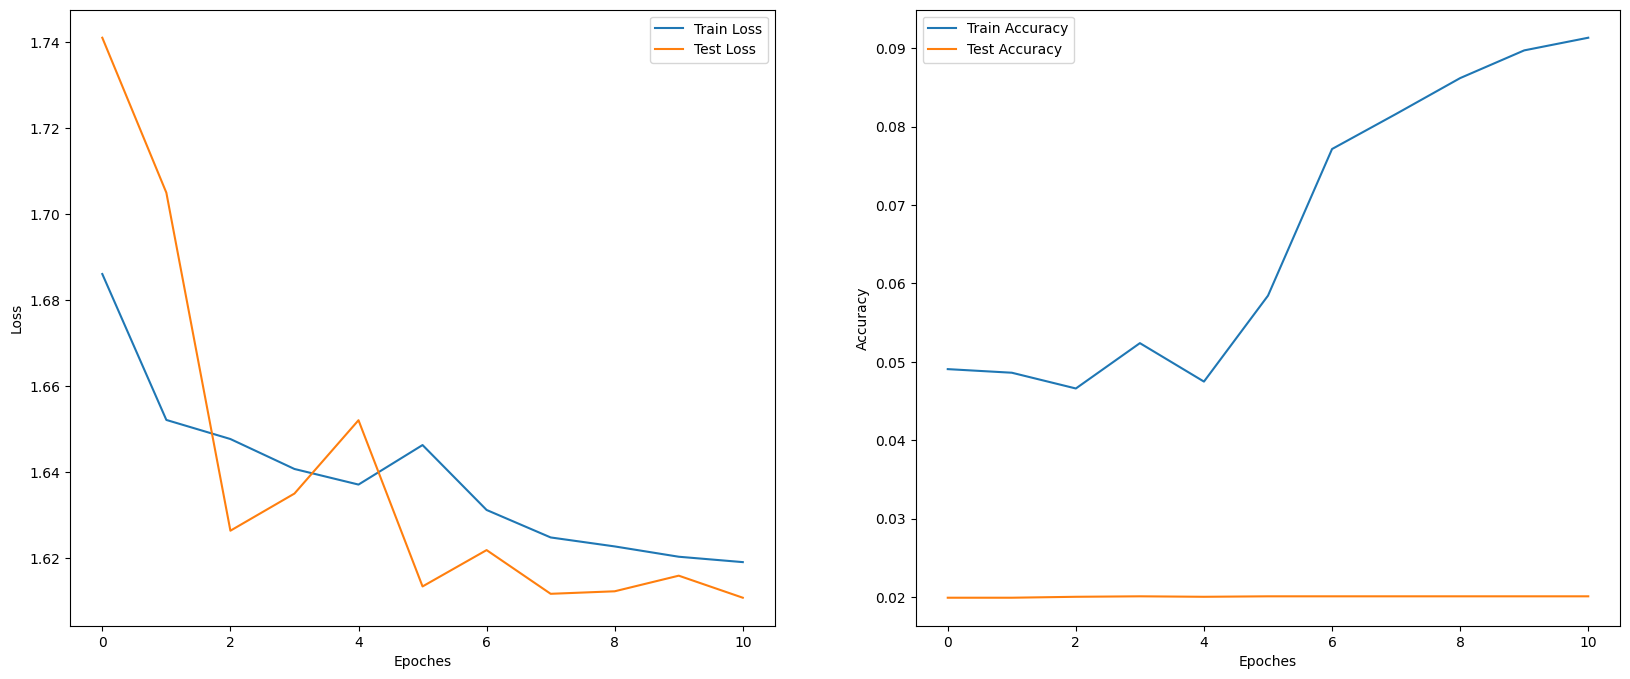

train ing time: 582.4674055289997


In [46]:
# init. epochs
epoches = 11

cos_pos_tanh = VisionTransformer(learn_pos_encode = False, num_heads = 8, num_blocks = 6, activation = 'tanh').to(device)

# optimizer
optimizer = torch.optim.Adam(params = cos_pos_tanh.parameters(), lr = 1e-3)
cos_pos_tanh_train_loss, cos_pos_tanh_test_loss = [], []
cos_pos_tanh_train_accs, cos_pos_tanh_test_accs = [], []


torch.manual_seed(64)
torch.cuda.manual_seed(64)
start_time = timer()
for epoch in tqdm(range(epoches)):

  train_loss, train_acc = train_loop(model = cos_pos_tanh, dataloader = train_dataloader,
                                    loss_fn = loss_fn, optimizer = optimizer,
                                    accuracy_fn = accuracy_fn, device = device)
  
  test_loss, test_acc = test_loop(model = cos_pos_tanh, dataloader = test_dataloader,
                                  loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                                  device = device)
  
  cos_pos_tanh_train_loss.append(train_loss.item())
  cos_pos_tanh_test_loss.append(test_loss.item())
  cos_pos_tanh_train_accs.append(train_acc.item())
  cos_pos_tanh_test_accs.append(test_acc.item())

  print(f"Epoch: {epoch+1}  Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Accuray: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")

end_time = timer()
plot_graph(cos_pos_tanh_train_loss, cos_pos_tanh_test_loss, cos_pos_tanh_train_accs, cos_pos_tanh_test_accs)
print(f"train ing time: {end_time - start_time}")

# save_model('cifair10_cos_pos_tanh.pth', cos_pos_tanh)
# print("Model saved")

## learn pos with tanh

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 1.6740 | Test Loss: 1.7703 | Train Accuray: 0.0423 | Test Accuracy: 0.0199
Epoch: 2  Train Loss: 1.6712 | Test Loss: 1.6821 | Train Accuray: 0.0537 | Test Accuracy: 0.0199
Epoch: 3  Train Loss: 1.6547 | Test Loss: 1.6346 | Train Accuray: 0.0703 | Test Accuracy: 0.0200
Epoch: 4  Train Loss: 1.6456 | Test Loss: 1.6461 | Train Accuray: 0.0734 | Test Accuracy: 0.0201
Epoch: 5  Train Loss: 1.6388 | Test Loss: 1.6148 | Train Accuray: 0.0757 | Test Accuracy: 0.0200
Epoch: 6  Train Loss: 1.6323 | Test Loss: 1.6215 | Train Accuray: 0.0827 | Test Accuracy: 0.0200
Epoch: 7  Train Loss: 1.6286 | Test Loss: 1.6165 | Train Accuray: 0.0890 | Test Accuracy: 0.0201
Epoch: 8  Train Loss: 1.6236 | Test Loss: 1.6118 | Train Accuray: 0.0896 | Test Accuracy: 0.0201
Epoch: 9  Train Loss: 1.6386 | Test Loss: 1.6225 | Train Accuray: 0.0761 | Test Accuracy: 0.0200
Epoch: 10  Train Loss: 1.6248 | Test Loss: 1.6321 | Train Accuray: 0.0687 | Test Accuracy: 0.0201
Epoch: 11  Train Loss: 1.6200

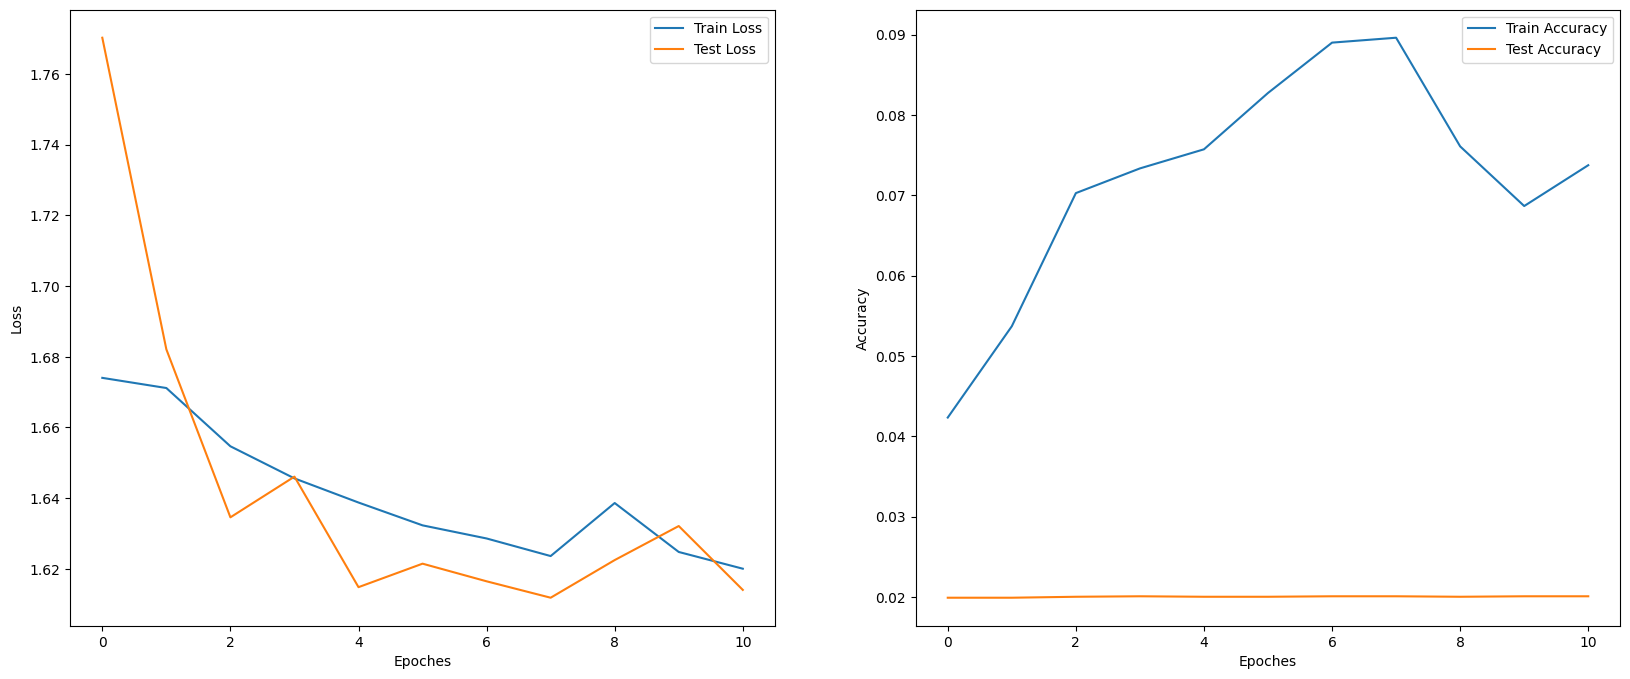

train ing time: 581.4097971070005


In [47]:
## learn pos with relu
# init. epochs
epoches = 11

learn_pos_tanh = VisionTransformer(learn_pos_encode = True, num_heads = 8, num_blocks = 6, activation = 'tanh').to(device)

# optimizer
optimizer = torch.optim.Adam(params = learn_pos_tanh.parameters(), lr = 1e-3)
learn_pos_tanh_train_loss, learn_pos_tanh_test_loss = [], []
learn_pos_tanh_train_accs, learn_pos_tanh_test_accs = [], []


torch.manual_seed(64)
torch.cuda.manual_seed(64)
start_time = timer()
for epoch in tqdm(range(epoches)):

  train_loss, train_acc = train_loop(model = learn_pos_tanh, dataloader = train_dataloader,
                                    loss_fn = loss_fn, optimizer = optimizer,
                                    accuracy_fn = accuracy_fn, device = device)
  
  test_loss, test_acc = test_loop(model = learn_pos_tanh, dataloader = test_dataloader,
                                  loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                                  device = device)
  
  learn_pos_tanh_train_loss.append(train_loss.item())
  learn_pos_tanh_test_loss.append(test_loss.item())
  learn_pos_tanh_train_accs.append(train_acc.item())
  learn_pos_tanh_test_accs.append(test_acc.item())

  print(f"Epoch: {epoch+1}  Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Accuray: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")

end_time = timer()
plot_graph(learn_pos_tanh_train_loss, learn_pos_tanh_test_loss, learn_pos_tanh_train_accs, learn_pos_tanh_test_accs)
print(f"train ing time: {end_time - start_time}")

# save_model('cifair10_learn_pos_tanh.pth', learn_pos_tanh)
# print("Model saved")